In [1]:
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import scipy.interpolate as inter

In [2]:
def rescale_flux(fluxA, fluxB, ratio0, ratio1):
    flux_new_A = (fluxA -1)*((1-ratio0)/(1-ratio1)) + 1
    flux_new_B = (fluxB -1)*(ratio0/ratio1) + 1
    return flux_new_A, flux_new_B

def slicedata(x_data, y_data, dictionary):
    x_data = pd.Series(x_data)
    y_data = pd.Series(y_data)
    x_data_sliced = []
    y_data_sliced = []
    for line in dictionary:
        reg = dictionary[line]['region']
        cond = (x_data > reg[0]) & (x_data < reg[1])
        x_data_sliced.append(np.array(x_data[cond]))
        y_data_sliced.append(np.array(y_data[cond]))
    return x_data_sliced, y_data_sliced

def crop_data(x_data, y_data, range1, range2):
    cond = (x_data < range1) | (x_data > range2)
    return x_data[cond], y_data[cond]

def chi2(obs, exp):
    return np.sum(((obs-exp)**2)/exp)

def He2H_ratio(wave, flux, ratio0, ratio1, dictionary, join=False):
    new_spetrum = []
    '''
    Modifies the He/H ratio
    It works on sliced data. Returns sliced data unless 'join' is True.
    '''
    for i,line in enumerate(dictionary):
        # print(line, len(wave[i]), len(flux[i]))
        # reg = dictionary[line]['region']
        # cond = (wave > reg[0]) & (wave < reg[1])
        if line in [4026, 4144, 4388]:
            new_spetrum.append( (flux[i] -1)*(ratio1/ratio0) + 1 )
        elif line==4121:
            reg_4121 = []
            cond1 = wave[i] < 4120
            cond2 = (wave[i] >= 4120) & (wave[i] < 4122)
            cond3 = wave[i] >= 4122
#             plt.plot(wave[i][cond1], flux[i][cond1])
            reg_4121.append( flux[i][cond1] )
            reg_4121.append( (flux[i][cond2] -1)*(ratio1/ratio0) + 1 )
            reg_4121.append( flux[i][cond3] )
            new_spetrum.append(np.array(list(itertools.chain.from_iterable(reg_4121))))
        elif line==4471:
            reg_4471 = []
            cond1 = wave[i] < 4468
            cond2 = (wave[i] >= 4468) & (wave[i] < 4475)
            cond3 = wave[i] >= 4475
#             plt.plot(wave[i][cond1], flux[i][cond1])
            reg_4471.append( flux[i][cond1] )
            reg_4471.append( (flux[i][cond2] -1)*(ratio1/ratio0) + 1 )
            reg_4471.append( flux[i][cond3] )
            new_spetrum.append(np.array(list(itertools.chain.from_iterable(reg_4471))))
        elif line in [4102, 4340]:
            new_spetrum.append(  (flux[i] -1)*((1-ratio1)/(1-ratio0)) + 1 )
        else:
            new_spetrum.append(flux[i])
#         print('length of new spectrum:', len(new_spetrum))
    if join==True:
        new_spetrum = np.array(list(itertools.chain.from_iterable(new_spetrum)))
        new_wave = np.array(list(itertools.chain.from_iterable(wave)))
#         print('length of joined wave and flux:', len(new_wave), len(new_spetrum))
        return new_wave, new_spetrum
    else:
        return new_spetrum

def rotin3_inp(grid, T, g, rot):
    '''
    grid: 'earlyB', 'lateB', 'O'
    '''
    import csv
    import os
    import subprocess

    lowT_models_path = '/home/jaime/science/KUL/atm_models/ATLAS9/Jaime/'
    tlustyB_path = '/home/jaime/science/KUL/atm_models/TLUSTY/BLvispec_v2/'
    tlustyO_path = '/home/jaime/science/KUL/atm_models/TLUSTY/OLvispec_v10/'
#
    H11_rotin = lowT_models_path+'r.dat'
    tlB_rotin = tlustyB_path+'291B.dat'
    tlO_rotin = tlustyO_path+'291B.dat'

    if grid == 'earlyB':
        inpfile = tlB_rotin
        path    = tlustyB_path
        model   = 'BL'
        vt      = '2'
        models_list = sorted(glob(path+'*v'+vt+'.vis.7'))
    elif grid == 'lateB':
        inpfile = H11_rotin
        path    = lowT_models_path
        model   = 't'
        models_list = sorted(glob(path+'*F.dat'))
    elif grid == 'O':
        inpfile = tlO_rotin
        path    = tlustyO_path
        model   = 'L'
        vt      = '10'
        models_list = sorted(glob(path+'*v'+vt+'.vis.7'))

    models_list = [x.replace(path, '') for x in models_list]

    # BL23000g300v2.vis.7        earlyB
    # t11000g26F.dat             lateB
    # L35000g450v10.vis.7        O

    df = pd.read_csv(inpfile, sep='\s+', header=None)
    # print(df)
    if grid=='earlyB' or grid=='O':
        df.loc[0, 0] = '\''+model+str(int(T*1000))+'g'+str(int(g*10))+'v'+str(vt)+'.vis.7\''
        # print(df.loc[0, 0].replace('\'', ''))
        # print(models_list[16])
        if df.loc[0, 0].replace('\'', '') in models_list:
            # print('Model', df.loc[0, 0], ' saved')
            df.loc[0, 1] = '\''+model+str(int(T*1000))+'g'+str(int(g*10))+'v'+str(vt)+'.vis.17\''
            df.loc[0, 2] = '\'T'+str(T)+'g'+str(int(g*10))+'v'+str(vt)+'r'+str(rot)+'fw05\''
            if grid=='O':
                df.loc[0, 2] = '\'T'+str(int(T*10))+'g'+str(int(g*10))+'v'+str(vt)+'r'+str(int(rot))+'fw05\''
            df.loc[1, 0] = rot
            # print(df)
            df.to_csv(inpfile, sep='\t', index=False, header=False)
            os.chdir(path)
            p=subprocess.run(['./rotin3.out < '+inpfile], text=True, check=True, shell=True)
            print('Model', df.loc[0, 2], ' saved')
    elif grid=='lateB':
        # print(inpfile)
        df.loc[0, 0] = '\''+model+str(int(T*1000))+'g'+str(int(g))+'F.dat\''
        # print(df.loc[0, 0].replace('\'', ''))
        if df.loc[0, 0].replace('\'', '') in models_list:
            df.loc[0, 1] = '\''+model+str(int(T*1000))+'g'+str(int(g))+'C.dat\''
            df.loc[0, 2] = '\'T'+str(T)+'g'+str(int(g))+'v2'+'r'+str(rot)+'fw05\''
            df.loc[1, 0] = rot
            # print(df)
            df.to_csv(inpfile, sep='\t', index=False, header=False)
            os.chdir(path)
            p=subprocess.run(['./rotin3.out < '+inpfile], text=True, check=True, shell=True)
            print('Model', df.loc[0, 0], ' saved')
        else:
            print('model is not in models_list')

def get_model(T, g, rot, source='tlusty'):
    '''
    source : Source of the models. Options are 'tlusty' and 'atlas'.
    '''

    lowT_models_path = '/home/jaime/science/KUL/atm_models/ATLAS9/Jaime/'
    tlustyB_path = '/home/jaime/science/KUL/atm_models/TLUSTY/BLvispec_v2/'
    tlustyO_path = '/home/jaime/science/KUL/atm_models/TLUSTY/OLvispec_v10/'


    # lowT_models_path = '/Users/jaime/Science/KUL_postdoc/KUL_research/models/ATLAS9/Jaime/'
    lowT_models_list = sorted(glob(lowT_models_path+'*fw05'))
    lowT_models_list = [x.replace(lowT_models_path, '') for x in lowT_models_list]
    # tlustyB_path = '/Users/jaime/Science/KUL_postdoc/KUL_research/models/tlusty/BLvispec_v2/'
    tlustyB_list = sorted(glob(tlustyB_path+'*fw05'))
    tlustyB_list = [x.replace(tlustyB_path, '') for x in tlustyB_list]
    # tlustyO_path = '/Users/jaime/Science/KUL_postdoc/KUL_research/models/tlusty/OLvispec_v10/'
    tlustyO_list = sorted(glob(tlustyO_path+'*fw05'))
    tlustyO_list = [x.replace(tlustyO_path, '') for x in tlustyO_list]
    tlustyOB_list = tlustyB_list + tlustyO_list
    model = 'T'+str(int(T))+'g'+str(int(g*10))+'v2r'+str(int(rot))+'fw05'
    if T>30:
        model = 'T'+str(int(T*10))+'g'+str(int(g*10))+'v10r'+str(int(rot))+'fw05'

    if source=='tlusty':
        if model in tlustyOB_list:
            if T>30 and g!=30:
                df = pd.read_csv(tlustyO_path+model,header=None, sep='\s+')
            else:
                df = pd.read_csv(tlustyB_path+model,header=None, sep='\s+')
            return df[0].array, df[1].array, model
        else:
            print('WARNING: No model named '+model+' was found')
            if T>30 and g!=30:
                try:
                    rotin3_inp('O', T, g, rot)
                    df = pd.read_csv(tlustyO_path+model,header=None, sep='\s+')
                    return df[0].array, df[1].array, model
                except FileNotFoundError:
                    raise ValueError('WARNING: No model named '+model+' was found')
            else:
                try:
                    rotin3_inp('earlyB', T, g, rot)
                    df = pd.read_csv(tlustyB_path+model,header=None, sep='\s+')
                    return df[0].array, df[1].array, model
                except FileNotFoundError:
                    raise ValueError('WARNING: No model named '+model+' was found')

    elif source=='atlas':
        model = 'T'+str(int(T))+'g'+str(int(g))+'v2r'+str(int(rot))+'fw05'
        if model in lowT_models_list:
            df = pd.read_csv(lowT_models_path+model,header=None, sep='\s+')
            return df[0].array, df[1].array, model
        else:
            try:
                print('Looking for model ', model)
                rotin3_inp('lateB', T, g, rot)
                df = pd.read_csv(lowT_models_path+model,header=None, sep='\s+')
                return df[0].array, df[1].array, model
            except FileNotFoundError:
                # print('WARNING: No model named '+model+' was found')
                raise ValueError('WARNING: No model named '+model+' was found')


lines_dic = {
                4026: { 'region':[4005, 4033], 'title':'He I $\lambda$4009/26'},
#                 4026: { 'region':[3990, 4033], 'title':'He I $\lambda$4009/26'},
                4102: { 'region':[4084-20, 4117], 'title':'H$\delta$'},
                4121: { 'region':[4117, 4135], 'title':'He I $\lambda$4121, Si II $\lambda$4128/32'},
                4144: { 'region':[4137, 4151], 'title':'He I $\lambda$414'},
                4267: { 'region':[4260, 4275], 'title':'C II $\lambda$4267'},
                4340: { 'region':[4320, 4362], 'title':'H$\gamma$'},
                4388: { 'region':[4380, 4396], 'title':'He I $\lambda$4388'},
                4471: { 'region':[4465, 4485], 'title':'He I $\lambda$4471, Mg II $\lambda$4481'},
                4553: { 'region':[4536, 4560], 'title':'Fe II $\lambda$4550/56, Si III $\lambda$4553'} }

# select_lines = [4009, 4026, 4102, 4121, 4144, 4340, 4388, 4471, 4553]
select_linesA = [4026, 4102, 4121, 4144, 4267, 4340, 4388, 4471, 4553]
select_linesB = [4026, 4102, 4121, 4144, 4267, 4340, 4388, 4553]
# select_linesA = [4026, 4102, 4121, 4144, 4267, 4340]
# select_linesB = [4026, 4121, 4144, 4267, 4388, 4553]
dicA = { line: lines_dic[line] for line in select_linesA }
dicB = { line: lines_dic[line] for line in select_linesB }

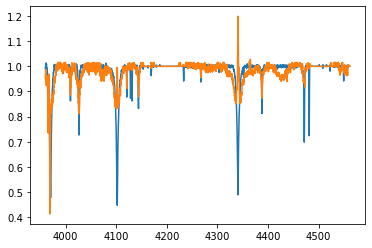

<class 'pandas.core.series.Series'>


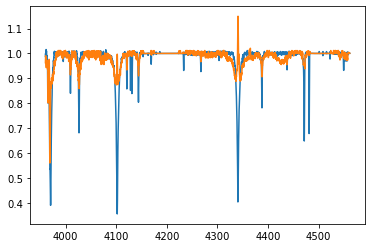

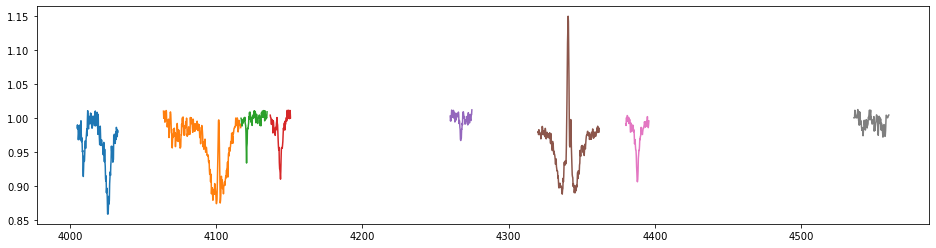

In [3]:
dsnt_A = pd.read_csv('/home/jaime/science/KUL/VFTS291/ADIS_lguess_K1K2=0.3_94.0_15.0_renorm.txt', header=None, sep='\s+')
dsnt_B = pd.read_csv('/home/jaime/science/KUL/VFTS291/BDIS_lguess_K1K2=0.3_94.0_15.0.txt', header=None, sep='\s+')

# print('Called with', params, T1, g1, T2, g2, r2)
lr, he2h = [0.40, 0.1]
#
dst_A_wave = dsnt_A[0]-0.2
dst_B_wave = dsnt_B[0]-0.2

plt.plot(dst_A_wave, dsnt_A[1])
plt.plot(dst_B_wave, dsnt_B[1])
plt.show()
plt.close()

dst_A_flux, dst_B_flux = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, lr)

plt.plot(dst_A_wave, dst_A_flux)
plt.plot(dst_B_wave, dst_B_flux)
print(type(dst_A_wave))
dst_A_x, dst_A_y = slicedata(dst_A_wave, dst_A_flux, dicA)
dst_B_x, dst_B_y = slicedata(dst_B_wave, dst_B_flux, dicB)

fig, ax = plt.subplots(figsize=(16,4))
for x,y in zip(dst_B_x, dst_B_y):
    plt.plot(x, y)

In [17]:
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.36)
df_A = pd.DataFrame(data={'wave': dsnt_A[0], 'flux': f_A})
df_B = pd.DataFrame(data={'wave': dsnt_B[0], 'flux': f_B})
df_A.to_csv('vfts291A_dsn_lrat36.asc', index=False, header=False, sep='\t')
df_B.to_csv('vfts291B_dsn_lrat36.asc', index=False, header=False, sep='\t')

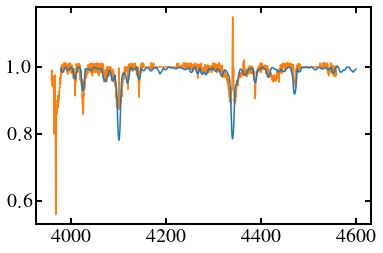

In [166]:
T1, g1, r1, T2, g2, r2 = 13, 24, 35, 24, 27.5, 300
# T1, g1, T2, g2, r2 = 14, 24, 26, 30.0, 100
modA_x, modA_y, modelA = get_model(T1, g1, r1, source='atlas')
modB_x, modB_y, modelB = get_model(T2, g2, r2, source='tlusty')
# modA_x, modA_y = modA_x.to_numpy(), modA_y.to_numpy()
# print(list(modA_x))
# modA_x, modA_y = list(modA_x), list(modA_y)
# print(type(modA_x))
plt.plot(modB_x, modB_y, zorder=1)
plt.plot(dst_B_wave, dst_B_flux, zorder=0)


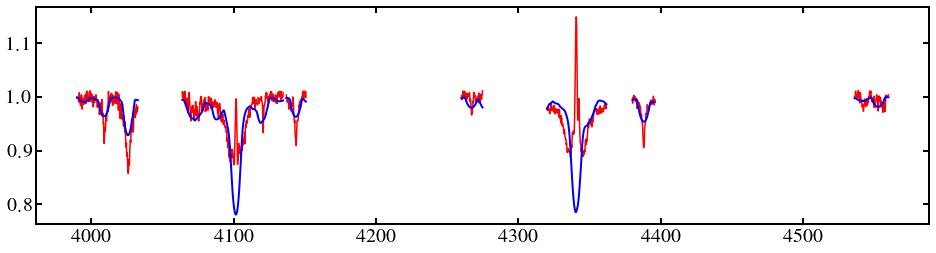

In [167]:
if modA_y and modB_y:
    splA = inter.UnivariateSpline(modA_x, modA_y)  
    splA.set_smoothing_factor(0.)
    # interpolation the flux to the wavelength scale of
    # the sliced disentangled data
    spl_fluxA = [splA(x) for x in dst_A_x]
    
    splB = inter.UnivariateSpline(modB_x, modB_y)
    splB.set_smoothing_factor(0.)
    spl_fluxB = [splB(x) for x in dst_B_x]
    fig, ax = plt.subplots(figsize=(16,4))
    for x,y in zip(dst_B_x, spl_fluxB):
        plt.plot(x, y, color='blue', lw=2, zorder=1)
    for x,y in zip(dst_B_x, dst_B_y):
        plt.plot(x, y, color='red', zorder=0)
    spl_fluxA = He2H_ratio(dst_A_x, spl_fluxA, 0.075, he2h, dicA)

4026 0.07982978235434432
4102 0.08514040227553092
4121 0.0448897497238123
4144 0.01922946579151281
4267 0.01314549767603986
4340 0.05697124415962349
4388 0.015345142012153163
4553 0.011231657692845346
chi2 A = 0.29654640949940236
chi2 B = 0.3257829416858622
chi2 total = 0.6223293511852646
# data A = 1225
# data B = 1025
chi2_r A = 0.00024346995853809719
chi2_r B = 0.0003200225360371927
chi2_r total = 0.0005634924945752899


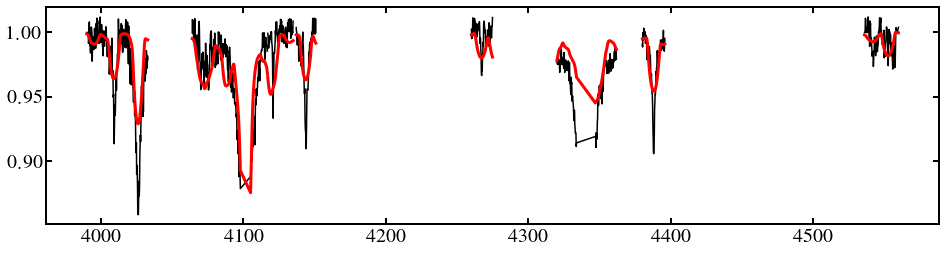

In [168]:
nparams = 7
chi2A, chi2B, ndataA, ndataB = 0, 0, 0, 0
fig, ax = plt.subplots(figsize=(16,4))
for i,line in enumerate(dicB):
    if line == 4102:
        dst_B_x_crop, dst_B_y_crop = crop_data(dst_B_x[i], dst_B_y[i], 4098, 4105)
        spl_wavB_crop, spl_fluxB_crop = crop_data(dst_B_x[i], spl_fluxB[i], 4098, 4105)
        plt.plot(dst_B_x_crop, dst_B_y_crop, 'k-')
        plt.plot(spl_wavB_crop, spl_fluxB_crop, 'r-', lw=3)
    elif line == 4340:
        dst_B_x_crop, dst_B_y_crop = crop_data(dst_B_x[i], dst_B_y[i], 4334, 4347)
        spl_wavB_crop, spl_fluxB_crop = crop_data(dst_B_x[i], spl_fluxB[i], 4334, 4347)
        plt.plot(dst_B_x_crop, dst_B_y_crop, 'k-')
        plt.plot(spl_wavB_crop, spl_fluxB_crop, 'r-', lw=3)
    else:
        dst_B_x_crop, dst_B_y_crop = dst_B_x[i], dst_B_y[i]
        plt.plot(dst_B_x_crop, dst_B_y_crop, 'k-')
        spl_wavB_crop, spl_fluxB_crop = dst_B_x[i], spl_fluxB[i]
        plt.plot(spl_wavB_crop, spl_fluxB_crop, 'r-', lw=3)
    
    ndataB += len(spl_fluxB_crop)
    print(line, chi2(dst_B_y_crop, spl_fluxB_crop))
    chi2B += chi2(dst_B_y_crop, spl_fluxB_crop)

for i,line in enumerate(dicA):
    chi2A += chi2(dst_A_y[i], spl_fluxA[i])
    ndataA += len(spl_fluxA[i])

chi2_tot = chi2A + chi2B
ndata = ndataA + ndataB

print('chi2 A =', chi2A)
print('chi2 B =', chi2B)
print('chi2 total =', chi2_tot)
print('# data A =', ndataA)
print('# data B =', ndataB)
chi2redA = chi2A/(ndataA-nparams)
chi2redB = chi2B/(ndataB-nparams)
print('chi2_r A =', chi2redA)
print('chi2_r B =', chi2redB)
print('chi2_r total =', chi2redA+chi2redB)

In [ ]:
0.35 0.05 14 24 35 
chi2 A = 0.60920734876882
chi2 B = 0.37506948079904295
chi2 total = 0.984276829567863

0.35 0.07 14 24 35 
chi2 A = 0.34371329986937643
chi2 B = 0.37506948079904295
chi2 total = 0.7187827806684194

0.35 0.1 14 24 35 
chi2 A = 0.37947612969134836
chi2 B = 0.37506948079904295
chi2 total = 0.7545456104903914

0.35 0.12 14 24 35 
chi2 A = 0.775367851595269
chi2 B = 0.37506948079904295
chi2 total = 1.150437332394312

0.35 0.14 14 24 35 
chi2 A = 1.575506014173659
chi2 B = 0.37506948079904295
chi2 total = 1.9505754949727019

In [ ]:
chi2 A = 0.4088763977293007
chi2 B = 0.3581329260802277
chi2 total = 0.7670093238095284
# data A = 1150
# data B = 575
chi2_r A = 0.00035772213274654476
chi2_r B = 0.0006305157149299783
chi2_r total = 0.000988237847676523

In [23]:
1150+950

2100

In [12]:
print(list(range(0, 600, 50)))

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]


In [10]:
# teffB = [24, 26, 28, 30, 32.5, 35, 37.5]
teffA = np.linspace(10, 18, 9, dtype=int)

rotA = np.linspace(10, 70, 7, dtype=int)

for T1 in teffA:
    if T1 < 16:
        loggA = [18, 20, 22, 24, 26, 28, 30]
        for g1 in loggA:
            for r1 in rotA:
                rotin3_inp('lateB', T1, g1, r1)
    else:
        loggA = [20, 22.5, 25, 27.5, 30]
        for g1 in loggA:
            for r1 in rotA:
                rotin3_inp('earlyB', T1, g1, r1)

Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g18F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g20F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g22F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g24F.dat'  saved
Model 't10000g26F.dat'  saved
Model 't10000g26F.dat'  saved
Model 't10000g26F.dat'  saved
Model 't10000g26F.dat'  saved
Model 't10000g26F.dat'  saved
Model 't10

In [13]:
teffB = [16, 18, 20, 22, 24, 26, 28, 30, 32.5, 35, 37.5]
# teffB = [16, 20]
loggB = [20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45]
# loggB = [42.5, 45]
rotB = range(0, 600, 50)

for T2 in teffB:
    for g2 in loggB:
        for r2 in rotB:
            if T2>30 and g2!=30:
                rotin3_inp('O', T2, g2, r2)
            else:
                rotin3_inp('earlyB', T2, g2, r2)

Model 'T16g200v2r0fw05'  saved
Model 'T16g200v2r50fw05'  saved
Model 'T16g200v2r100fw05'  saved
Model 'T16g200v2r150fw05'  saved
Model 'T16g200v2r200fw05'  saved
Model 'T16g200v2r250fw05'  saved
Model 'T16g200v2r300fw05'  saved
Model 'T16g200v2r350fw05'  saved
Model 'T16g200v2r400fw05'  saved
Model 'T16g200v2r450fw05'  saved
Model 'T16g200v2r500fw05'  saved
Model 'T16g200v2r550fw05'  saved
Model 'T16g225v2r0fw05'  saved
Model 'T16g225v2r50fw05'  saved
Model 'T16g225v2r100fw05'  saved
Model 'T16g225v2r150fw05'  saved
Model 'T16g225v2r200fw05'  saved
Model 'T16g225v2r250fw05'  saved
Model 'T16g225v2r300fw05'  saved
Model 'T16g225v2r350fw05'  saved
Model 'T16g225v2r400fw05'  saved
Model 'T16g225v2r450fw05'  saved
Model 'T16g225v2r500fw05'  saved
Model 'T16g225v2r550fw05'  saved
Model 'T16g250v2r0fw05'  saved
Model 'T16g250v2r50fw05'  saved
Model 'T16g250v2r100fw05'  saved
Model 'T16g250v2r150fw05'  saved
Model 'T16g250v2r200fw05'  saved
Model 'T16g250v2r250fw05'  saved
Model 'T16g250v2r30

In [5]:
def fitplot(wA, fA, wM, fM, model, lr, dictionary, lines, figu='save', nrows=3, ncols=3, legend_ax=3,
            xlabel_ax=7, ylabel_ax=3, balmer_min_y=0.75):
    '''
    wA, fA : wavelength and flux of the observed spectrum.
    wM, fM : wavelength and flux of the mdoels (list).
    model  : name/identifier of the models. Used for labels in legend (list).
    lr     : light ratio contribution from the secondary. Used in figure title and name of the saved plot.
    dictionary : Python dictionary with name/identifier on the spectral lines, the region and title for each subplot.
    lines  : lines used in the dictionary (list).
    #savefig : default False. True will save the figure (bool).
    figu : default 'save'. Use 'show' to show the plot without saving it.
    nrows, ncols : number of rows and columns for subplots (int).
    legend_ax : number of the preferred subplot to display the legend (int).
    '''
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.5*nrows), sharey=False)
    if type(axes)==np.ndarray:
        ax = axes.flatten()
    else:
        ax = [axes]
    for i, line in enumerate(dictionary):
        reg = dictionary[line]['region']
        cond = (wA > reg[0]) & (wA < reg[1])
        ax[i].plot(wA[cond], fA[cond],c='k',ls='-', linewidth=4, label='disent. spec')
        # ax[i].plot(wA[cond], fA[cond], 'ko', ms=8,ls='none', label='disent. spec')
        for f, w, mod in zip(fM, wM, model):
            cond = (w > reg[0]) & (w < reg[1])
#             ax[i].plot(w[cond], f[cond],'--', c='orange', linewidth=4, label=mod)
            ax[i].plot(w[cond], f[cond],'--', linewidth=4, label=mod)
        if line in [4102, 4340]:
            ax[i].set_ylim(balmer_min_y, 1.05)
#         elif line in [4026]:
#             ax[i].set_ylim(0.95, 1.05)
        ax[i].set_title(dictionary[line]['title'], size=30)
        ax[i].tick_params(axis='both', which='major', labelsize=32)
#     ax[legend_ax].legend(frameon=False, fontsize=20)
    fig.supxlabel(r'Wavelength (\AA)', size=48)
    fig.supylabel(r'Flux', x=0.01, size=48)
#     fig.suptitle('Secondary light contribution = '+str(int(lr))+'\%'+' - fitted lines: '+str(lines), y=1, fontsize=36)
#     fig.suptitle('Secondary light contribution = '+str(int(lr))+'%', y=1, fontsize=36)
    plt.tight_layout()
    if figu=='save':
    # plt.savefig(model+'lr'+str(lr)+'_'+str(lines)+'.pdf')
#         plt.savefig(str(model[0])+'_lr'+str(int(lr))+'.png', dpi=100)
        plt.savefig(str(model[0])+'_lr'+str(int(lr))+'.pdf')
#     else:
    plt.show()
    plt.close()

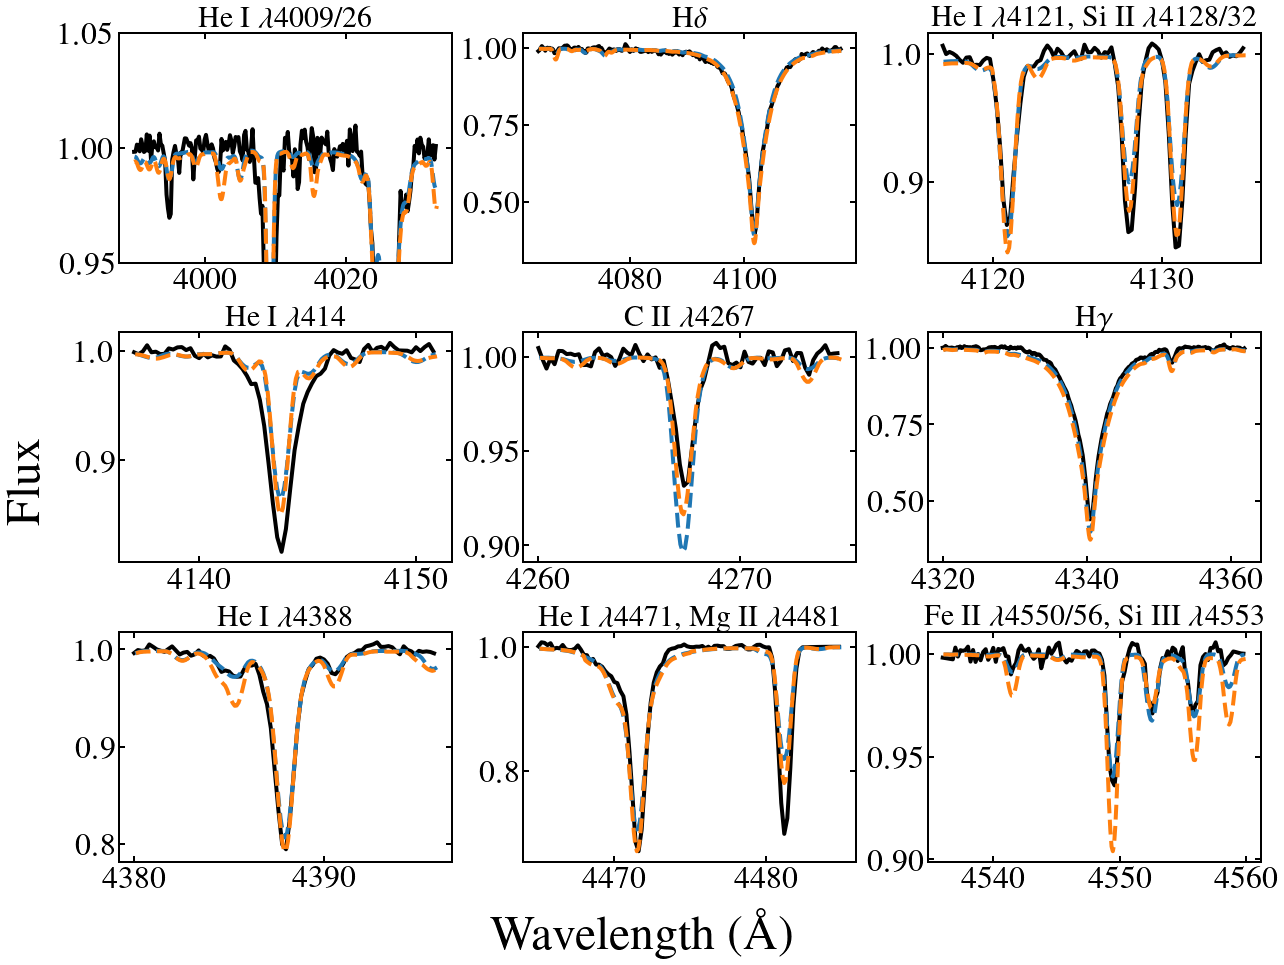

In [144]:
import myRC
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.36)
# f_A2, f_B2 = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.35)

modA_w, modA_f, modelA = get_model(14, 24, 40, 'atlas')
modA_w2, modA_f2, modelA2 = get_model(13, 24, 35, 'atlas')

# print(modelA)

modslc_A_x, modslc_A_y = slicedata(modA_w, modA_f, dicA)
modslc_A_x2, modslc_A_y2 = slicedata(modA_w2, modA_f2, dicA)

# for he2h in [0.075, 0.1, 0.15, 0.2]:
modA_w_he, modA_f_he = He2H_ratio(modslc_A_x, modslc_A_y, 0.075, 0.08, dicA, join=True)
modA_w_he2, modA_f_he2 = He2H_ratio(modslc_A_x2, modslc_A_y2, 0.075, 0.1, dicA, join=True)

# plt.plot(modA_w_he, modA_f_he)
import os
os.chdir('/home/jaime/science/KUL/')
fitplot(dsnt_A[0]-0.2, f_A, [np.array(modA_w_he), np.array(modA_w_he2)], \
                            [np.array(modA_f_he), np.array(modA_f_he2)], \
                            [modelA, modelA2], 35, lines_dic, select_linesA, figu='save', legend_ax=7, balmer_min_y=0.3)

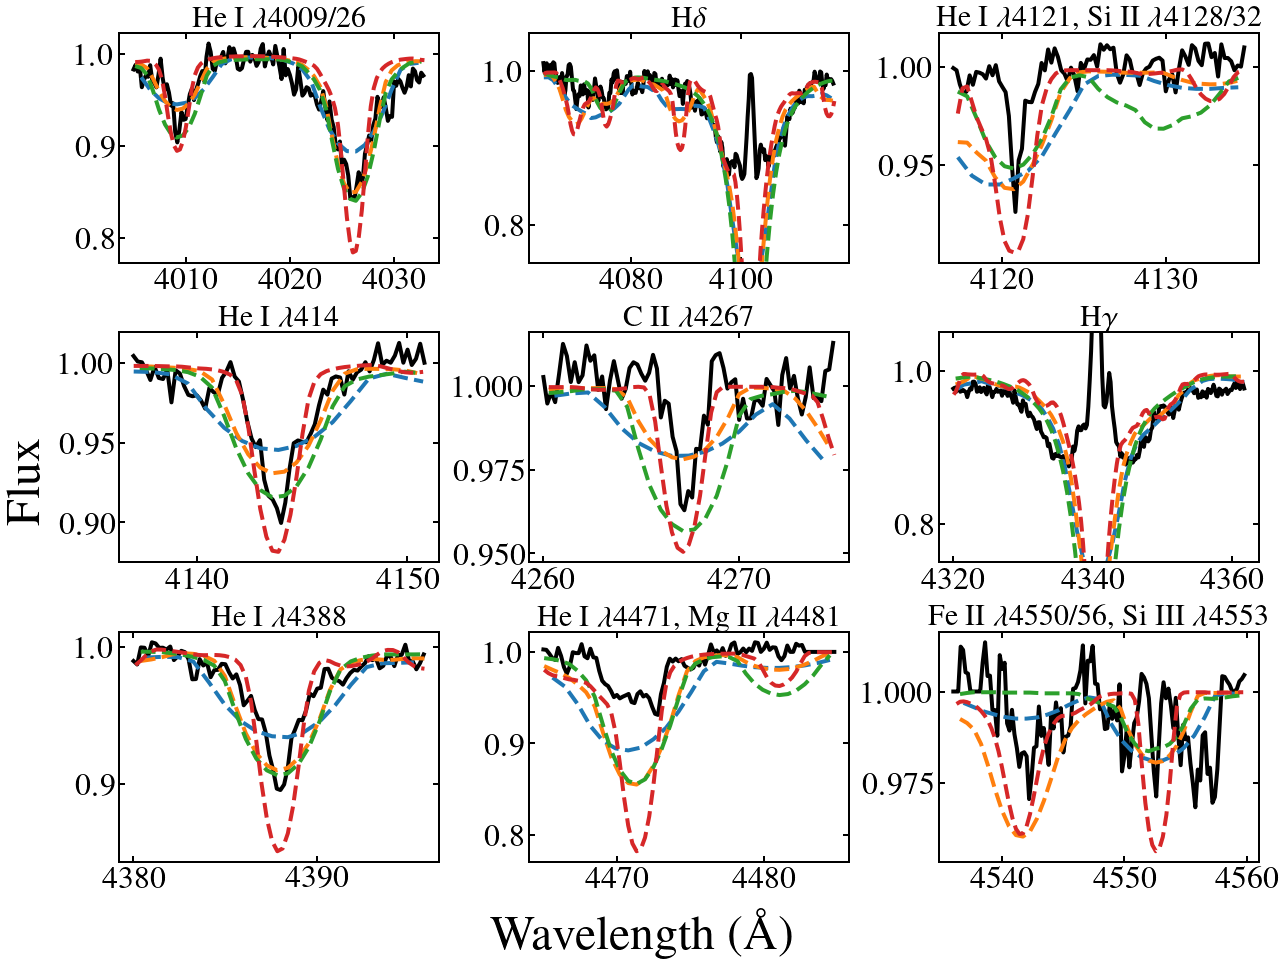

In [196]:
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.36)

# mod0: 0.40 0.10  A: 13 - 24.0 - 35 /  B: 24.0 - 27.5 - 300 / chi2: 0.630489 - 0.309208 - 0.321281
# mod0: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 26.0 - 32.5 - 300 / chi2: 0.638858 - 0.282157 - 0.356701
# mod1: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 30.0 - 35.0 - 200 / chi2: 0.640271 - 0.282157 - 0.358114
# mod2: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 16.0 - 27.5 - 200 / chi2: 0.618753 - 0.282157 - 0.336595

# modB_w0, modB_f0, modelB0 = get_model(24, 27.5, 300, 'tlusty')
modB_w0, modB_f0, modelB0 = get_model(26, 32.5, 300, 'tlusty')
modB_w1, modB_f1, modelB1 = get_model(30, 35, 200, 'tlusty')
modB_w2, modB_f2, modelB2 = get_model(16, 27.5, 200, 'tlusty')
modB_w3, modB_f3, modelB3 = get_model(28, 32.5, 100, 'tlusty')
os.chdir('/home/jaime/science/KUL/')
fitplot(dsnt_B[0]-0.2, f_B, [np.array(modB_w0), np.array(modB_w1), np.array(modB_w2), np.array(modB_w3)], \
                            [np.array(modB_f0), np.array(modB_f1), np.array(modB_f2), np.array(modB_f3)], \
        [modelB0, modelB1, modelB2, modelB3], 36, lines_dic, select_linesB, figu='save', legend_ax=7)

In [ ]:
'''B: T=16, logg=2.5, rot=300'''
4026 0.04046319186675537
4102 0.06904507264905642
4121 0.04389752528121704
4144 0.021488719292972053
4267 0.02157034859131017
4340 0.05594371225183273
4388 0.017104019746099167
4553 0.01158589837203647
chi2 A = 0.3560394280317999
chi2 B = 0.2810984880512794
chi2 total = 0.6371379160830792
# data A = 1150
# data B = 950
chi2_r A = 0.0003114955625825021
chi2_r B = 0.00029808959496424115
chi2_r total = 0.0006095851575467432

'''B: T=26, logg=3.0, rot=200'''
4026 0.13190204475120682
4102 0.11644118257663408
4121 0.04489608252333622
4144 0.02802762300998604
4267 0.014368313646449521
4340 0.0923452708139594
4388 0.022932084641830452
4553 0.01380602349780187
chi2 A = 0.26576154045239936
chi2 B = 0.46471862546120435
chi2 total = 0.7304801659136038
# data A = 1225
# data B = 1025
chi2_r A = 0.00021819502500196992
chi2_r B = 0.00045650159672024
chi2_r total = 0.00067469662172221


'''B: T=30, logg=3.5, rot=200'''
4026 0.04667187492116715
4102 0.13140712467842156
4121 0.05485031055859698
4144 0.01374345537518488
4267 0.009695092499182342
4340 0.03387040066134973
4388 0.02298847807220081
4553 0.03248982993278473
chi2 A = 0.3560394280317999
chi2 B = 0.3457165666988882
chi2 total = 0.7017559947306881
# data A = 1150
# data B = 950
chi2_r A = 0.0003114955625825021
chi2_r B = 0.000366613538386944
chi2_r total = 0.000678109100969446

In [68]:
print('delta chi2B Hd =', round(0.13140712467842156-0.06904507264905642, 3))
print('delta chi2B    =', round(0.3457165666988882-0.2810984880512794, 3))
print('delta chi2 tot =', round(0.7017559947306881-0.6371379160830792, 3))

delta chi2B Hd = 0.062
delta chi2B    = 0.065
delta chi2 tot = 0.065


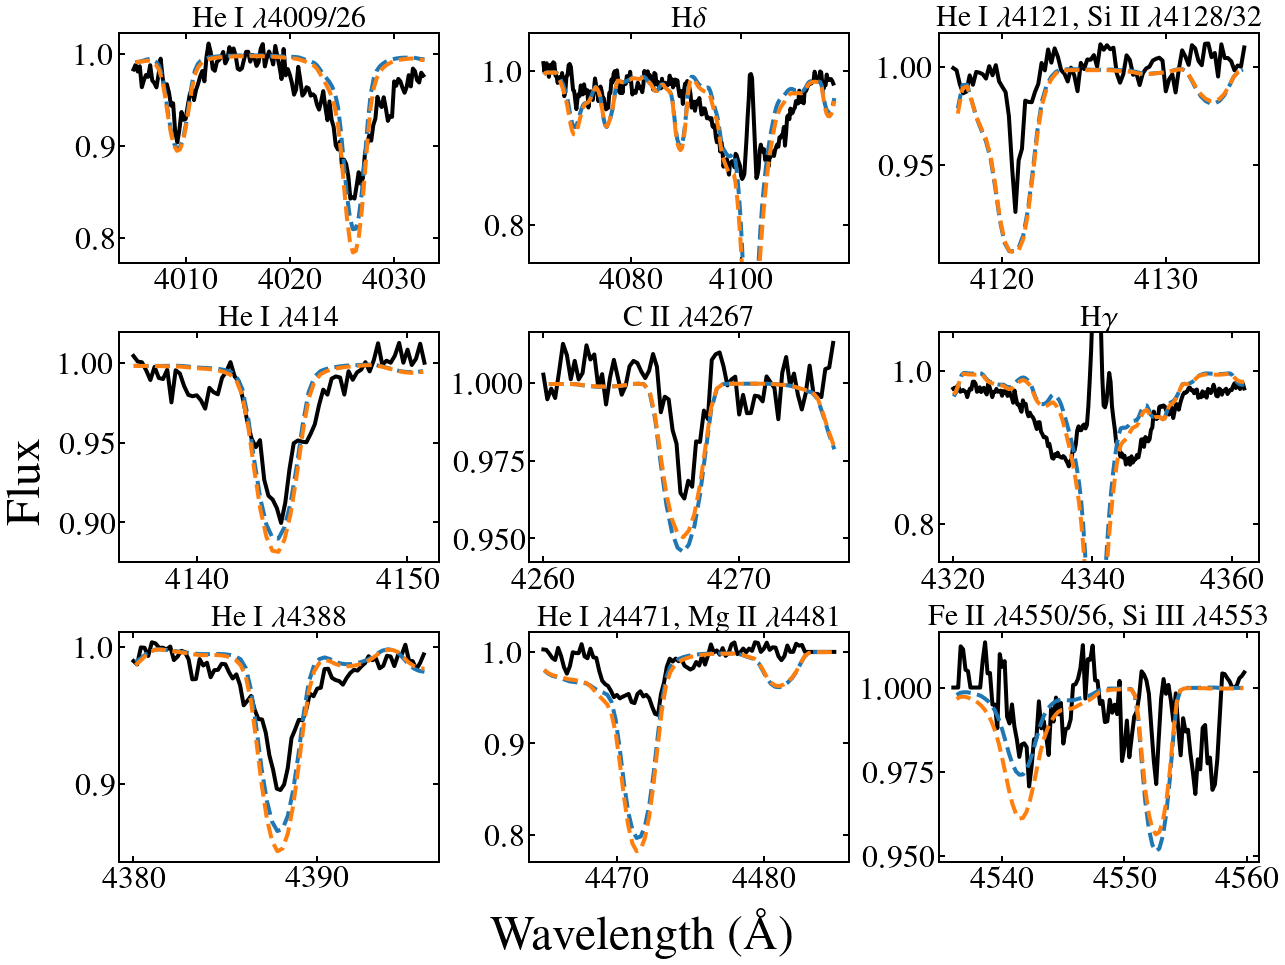

In [194]:
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.36)

# mod0: 0.40 0.10  A: 13 - 24.0 - 35 /  B: 24.0 - 27.5 - 300 / chi2: 0.630489 - 0.309208 - 0.321281
# mod0: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 26.0 - 32.5 - 300 / chi2: 0.638858 - 0.282157 - 0.356701
# mod1: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 30.0 - 35.0 - 200 / chi2: 0.640271 - 0.282157 - 0.358114
# mod2: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 16.0 - 27.5 - 200 / chi2: 0.618753 - 0.282157 - 0.336595

# modB_w0, modB_f0, modelB0 = get_model(24, 27.5, 300, 'tlusty')
modB_w0, modB_f0, modelB0 = get_model(26, 30, 100, 'tlusty')
modB_w1, modB_f1, modelB1 = get_model(28, 32.5, 100, 'tlusty')
# modB_w2, modB_f2, modelB2 = get_model(30, 40, 50, 'tlusty')
fitplot(dsnt_B[0]-0.2, f_B, [np.array(modB_w0), np.array(modB_w1)], #np.array(modB_w2)], \
                            [np.array(modB_f0), np.array(modB_f1)], #np.array(modB_f2)], \
        [modelB0, modelB1], 36, lines_dic, select_linesB, figu='show', legend_ax=7)

In [ ]:
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.5)

# mod0: 0.40 0.10  A: 13 - 24.0 - 35 /  B: 24.0 - 27.5 - 300 / chi2: 0.630489 - 0.309208 - 0.321281
# mod0: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 26.0 - 32.5 - 300 / chi2: 0.638858 - 0.282157 - 0.356701
# mod1: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 30.0 - 35.0 - 200 / chi2: 0.640271 - 0.282157 - 0.358114
# mod2: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 16.0 - 27.5 - 200 / chi2: 0.618753 - 0.282157 - 0.336595

# modB_w0, modB_f0, modelB0 = get_model(

Model 'T24g425v2r50fw05'  saved


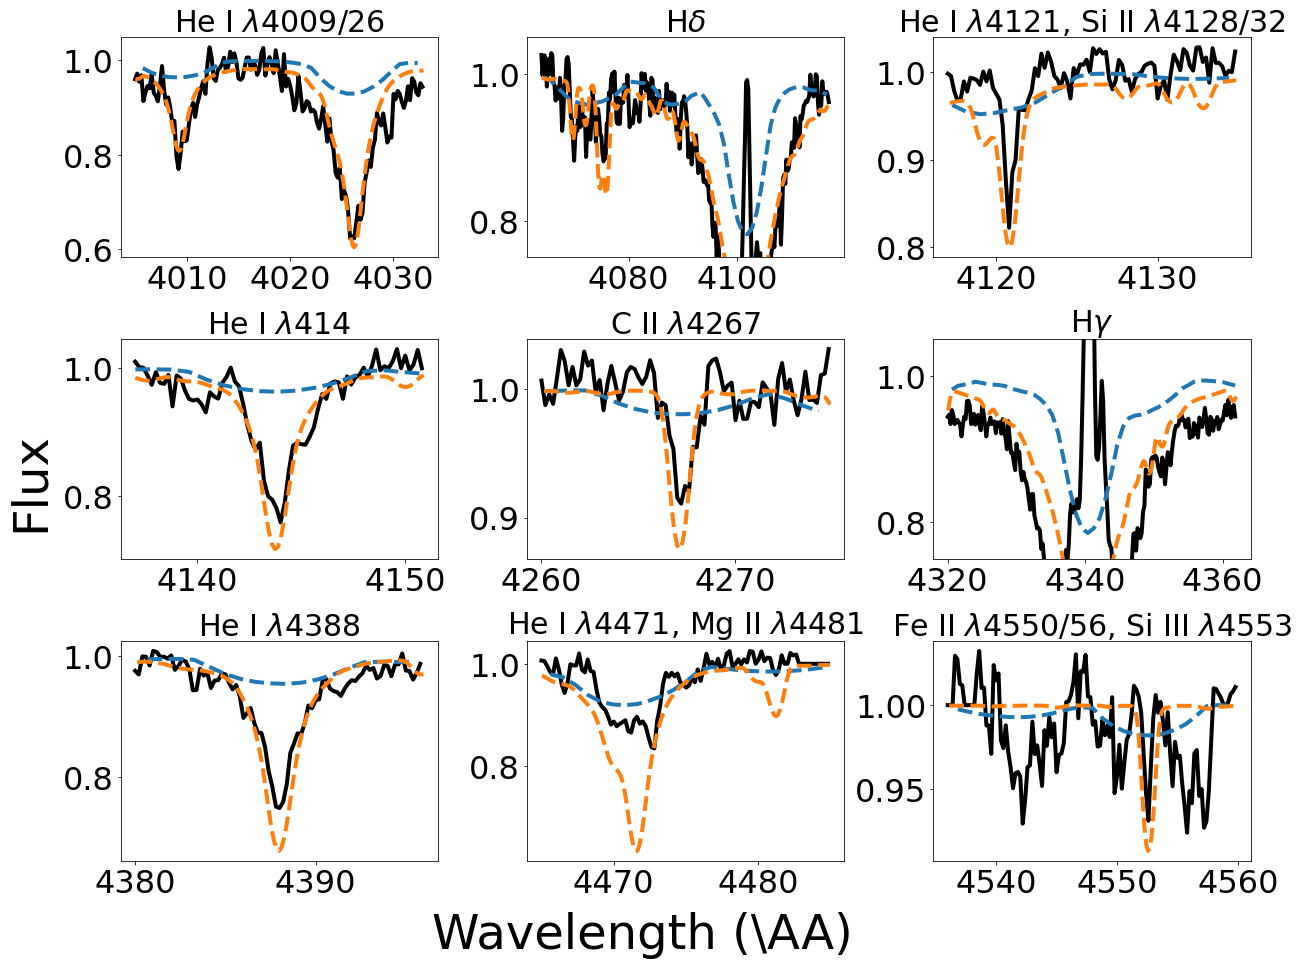

In [14]:
f_A, f_B = rescale_flux(dsnt_A[1], dsnt_B[1], 0.3, 0.15)

# mod0: 0.40 0.10  A: 13 - 24.0 - 35 /  B: 24.0 - 27.5 - 300 / chi2: 0.630489 - 0.309208 - 0.321281
# mod0: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 26.0 - 32.5 - 300 / chi2: 0.638858 - 0.282157 - 0.356701
# mod1: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 30.0 - 35.0 - 200 / chi2: 0.640271 - 0.282157 - 0.358114
# mod2: 0.35 0.08  A: 14 - 24.0 - 40 /  B: 16.0 - 27.5 - 200 / chi2: 0.618753 - 0.282157 - 0.336595

modB_w0, modB_f0, modelB0 = get_model(24, 27.5, 300, 'tlusty')
#modB_w0, modB_f0, modelB0 = get_model(26, 30, 100, 'tlusty')
modB_w1, modB_f1, modelB1 = get_model(24, 42.5, 50, 'tlusty')
# modB_w2, modB_f2, modelB2 = get_model(30, 40, 50, 'tlusty')
fitplot(dsnt_B[0]-0.2, f_B, [np.array(modB_w0), np.array(modB_w1)], #np.array(modB_w2)], \
                            [np.array(modB_f0), np.array(modB_f1)], #np.array(modB_f2)], \
        [modelB0, modelB1], 36, lines_dic, select_linesB, figu='show', legend_ax=7)